# A Fast Voxel Traversal Algorithm

## Introduction

This is the algorithm used to track particles in the voxels. It is modified from the original algorithm by Woo to allow the detection of passing through the corner of a voxel

## References:
- [A Fast Voxel Traversal Algorithm for Ray Tracing](http://www.cse.yorku.ca/~amana/research/grid.pdf)
- [https://stackoverflow.com/questions/55263298/draw-all-voxels-that-pass-through-a-3d-line-in-3d-voxel-space](https://stackoverflow.com/questions/55263298/draw-all-voxels-that-pass-through-a-3d-line-in-3d-voxel-space)

## Demo

Use the function `gen_trj` to test the algorithm

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

# create discrete colormap
dx = [1, 1, 1]
nx = [5, 5, 5]
dim = len(dx)
xmin = [0] * dim
xmax = [i * j for i, j in zip(dx, nx)]
eps = dx[0]*1e-6
x_ = []

for xmini, xmaxi, dxi, nxi in zip(xmin, xmax, dx, nx):
    x_.append(np.arange(xmini, xmaxi + dxi, dxi))

def locate_voxel(x):
    r = []
    for xi, xmini, xmaxi, nxi, dxi in zip(x, xmin, xmax, nx, dx):
        if xi < xmini - eps:
            r.append(-1)
        elif xi > xmaxi + eps:
            r.append(nxi)
        else:
            r.append(max(0, min(nxi-1, int((xi - xmini) / dxi))))
    return r


cmap = colors.ListedColormap(['white', 'blue'])
bounds = [0, 10, 20]
norm = colors.BoundaryNorm(bounds, cmap.N)


def gen_trj(x0, x, plot2d=True, plot3d=True):
    x_old = x.copy()
    x0_old = x0.copy()

    v = x - x0  # time to move from start to end is 1 unit
    t_eps = eps / np.linalg.norm(v, ord=np.inf)
    print("t_eps = ", t_eps)

    # check if x0 or x is not in the domain
    dt_move_x = 0
    idim_move_x = []
    for i, xx in enumerate(x):
        if xx > xmax[i]-eps:
            dt = (xx - xmax[i]) / v[i]
            if dt > dt_move_x:
                dt_move_x = dt
                idim_move_x = [i]
            elif dt == dt_move_x:
                idim_move_x.append(i)
        elif xx < xmin[i]+eps:
            dt = (xx - xmin[i]) / v[i]
            if dt > dt_move_x:
                dt_move_x = dt
                idim_move_x = [i]
            elif dt == dt_move_x:
                idim_move_x.append(i)
    if len(idim_move_x) > 0:
        print(f'move x backward by {dt_move_x}')
        x = x - dt_move_x * v

    print('xf=',x)

    dt_move_x0 = 0.0
    for i, xx in enumerate(x0):
        if xx > xmax[i]:
            dt_move_x0 = max((xmax[i] - xx) / v[i], dt_move_x0)
        elif xx < xmin[i]:
            dt_move_x0 = max((xmin[i] - xx) / v[i], dt_move_x0)
    if dt_move_x > 0.0:
        print(f'move x0 forward by {dt_move_x0}')
        print(dt_move_x0)
        x0 = x0 + dt_move_x0 * v

    v = x - x0

    ix0 = locate_voxel(x0)
    ix = locate_voxel(x)

    # determine moving direction
    step = np.zeros(dim, dtype=int)
    for i in range(dim):
        if v[i] < 0:
            step[i] = -1
        elif v[i] > 0:
            step[i] = 1

    # initialize tMax
    # if no movement on one direction, make time 2
    tMax = np.ones(dim)*(+np.Infinity)
    tDelta = np.zeros(dim)

    for i in range(dim):
        ix0i = ix0[i]
        x0i = x0[i]
        xi = x[i]
        if step[i] != 0:
            tDelta[i] = dx[i] / abs(v[i])
            if step[i] == 1:
                tMax[i] = (x_[i][ix0i + 1] - x0i) / v[i]
            elif step[i] == -1:
                tMax[i] = (x_[i][ix0i] - x0i) / v[i]
            if tMax[i] == 0.0:
                # If particle is on a cell surface, skip a move
                tMax[i] += tDelta[i]
                ix0[i] += step[i]

    ixc = [*ix0, -1, -1]
    ix_path = [ixc[:]]
    while min(tMax) < 1.0 - t_eps:
        idim_move = np.argwhere(tMax == np.amin(tMax)).flatten().tolist()

        for idim in idim_move:
            ixc[idim] += step[idim]
            tMax[idim] += tDelta[idim]

        if len(idim_move) == 1:
            idim = idim_move[0]
            ixc[dim] = idim
            if step[idim] == 1:
                # ray going up, pass lower surface
                ixc[dim+1] = 0
            elif step[idim] == -1:
                # ray going down, pass upper surface
                ixc[dim+1] = 1
            elif step[idim] == 0:
                raise ValueError("Shouldn't got here")
        else:
            # doesn't pass any surface, go throught corner
            ixc[dim] = -1
            ixc[dim+1] = -1
        ix_path.append(ixc[:])
        print("tMax = ", tMax)

    if len(idim_move_x) > 0:
        if len(idim_move_x) == 1:
            pos = ix_path[-1]
            idim = int(idim_move_x[0])
            low_high = int((step[idim_move_x[0]]+1)/2)

            # ix_path.append([*pos, idim, low_high])
            s_ax = ['x', 'y', 'z']
            s_d = ['-', '+']
            print("Particle touches a boundary at " +
                  s_d[low_high] + s_ax[idim])
        else:
            print("Particle touches more than one boundaries")
    elif min(tMax) < 1 + t_eps:
        # check if the final point is on a surface
        idim_on_surface = np.argwhere(np.abs(tMax-1.0) < t_eps)
        last_ixc = ix_path[-1]
        if len(idim_on_surface) == 1:
            s_ax = ['x', 'y', 'z']
            s_d = ['-', '+']
            pos = ix_path[-1][:dim]
            idim = int(idim_on_surface[0])
            direct = int((step[idim_on_surface[0]]+1)/2)
            ix_path.append([*pos, idim, direct])
            print("Particle touches a cell surface at ({:s}) {:s}{:s}".format(
                ",".join([str(i) for i in pos]), s_d[direct], s_ax[idim]))

        elif len(idim_on_surface) > 1:
            ix_path.append([*last_ixc[:dim], -1, -1])
            if len(idim_on_surface) == 2:
                print("Particle touches an edge")
            elif len(idim_on_surface) == 3:
                print("Particle touches a vertex")


    fig = plt.figure()
    fig.suptitle('x0=[{:s}] x=[{:s}]'.format(
        ','.join([f'{i:.2f}' for i in x0_old]), ','.join([f'{i:.2f}' for i in x_old])))

    if plot2d:
        # 2D plot
        data = np.zeros((nx[0], nx[1])) * 20
        row, col, page, _, _ = zip(*ix_path)
        data[col, row] = 15
        [m, n] = data.shape
        extent = [[i, j] for i, j in zip(xmin[:2], xmax[:2])]
        extent = tuple([ii for i in extent for ii in i])
        ax = fig.add_subplot(221)
        ax.imshow(data, cmap=cmap, norm=norm, origin='lower', extent=extent)
        ax.grid(which='major', axis='both',
                linestyle='-', color='k', linewidth=2)
        ax.set_xticks(x_[0])
        ax.set_yticks(x_[1])
        ax.quiver(x0[0], x0[1], v[0], v[1], scale_units='xy',
                  angles='xy', scale=1, headwidth=10)
        ax.plot([x0[0], x[0]], [x0[1], x[1]], 'ko-')
        for s in ix_path:
            idim = s[dim]
            if idim >= 0 and idim < 2:
                low_high = s[dim+1]

                edge_start = [
                    s[i] * dx[i] + xmin[i] for i in range(2)
                ]

                edge_end = [
                    (s[i]+1) * dx[i] + xmin[i] for i in range(2)
                ]

                if low_high == 0:
                    edge_end[idim] = edge_start[idim]
                else:
                    edge_start[idim] = edge_end[idim]

                ax.plot([edge_start[0], edge_end[0]], [
                        edge_start[1], edge_end[1]], 'y')


    if plot3d:
        # 3D plot
        x_3d, y_3d, z_3d = np.meshgrid(*x_, indexing='ij')
        row, col, page, _, _ = zip(*ix_path)

        voxels = np.zeros((nx[0], nx[1], nx[2]))
        voxels[row, col, page] = 1

        colors = np.empty(voxels.shape, dtype=object)
        colors = [0, 0, 1, 0.5]

        ax = fig.add_subplot(222, projection='3d')
        ax.voxels(x_3d, y_3d, z_3d, voxels, facecolors=colors, edgecolor='k')
        ax.quiver(x0[0], x0[1], x0[2], v[0], v[1], v[2], length=1)
        ax.plot([x0[0], x[0]], [x0[1], x[1]], [x0[2], x[2]], 'ko-')

    axt = fig.add_subplot(2, 2, (3, 4))
    axt.axis('off')
    cell_text = []
    for i in ix_path:
        cell_text.append(
            [f'{ii:d}' for ii in i[:dim]]
        )
    cell_label = ['x', 'y', 'z']
    if dim == 2:
        cell_label = cell_label[:2]
    table = axt.table(cellText=cell_text, colLabels=cell_label, loc='center')
    return ix_path


t_eps =  1.176470588235294e-07
move x backward by 0.4117647058823529
xf= [4.52941176 5.         0.5       ]
move x0 forward by 0.0
0.0
tMax =  [0.28333333 0.4               inf]
tMax =  [0.56666667 0.4               inf]
tMax =  [0.56666667 0.6               inf]
tMax =  [0.85 0.6   inf]
tMax =  [0.85 0.8   inf]
tMax =  [0.85 1.    inf]
tMax =  [1.13333333 1.                inf]
Particle touches a boundary at +y
[[1, 0, 0, -1, -1], [1, 1, 0, 1, 0], [2, 1, 0, 0, 0], [2, 2, 0, 1, 0], [3, 2, 0, 0, 0], [3, 3, 0, 1, 0], [3, 4, 0, 1, 0], [4, 4, 0, 0, 0]]


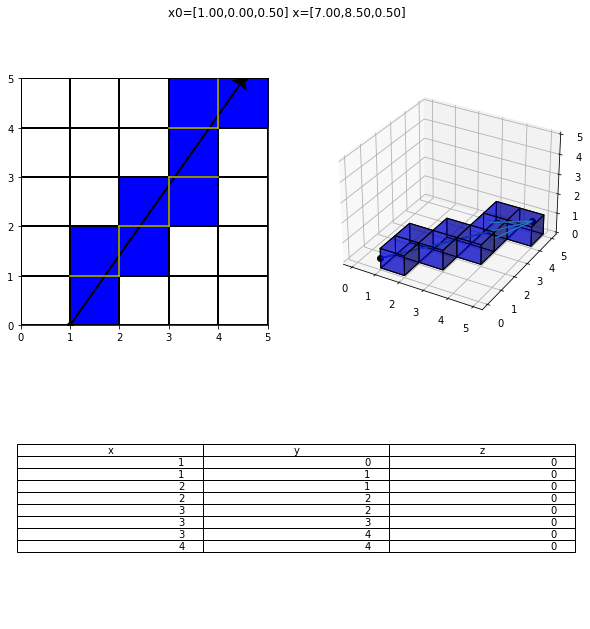

In [4]:
# cross boundary
x0 = np.array([1, 0, 0.5])
x = np.array([7, 8.5, 0.5])
print(gen_trj(x0, x))

t_eps =  2.857142857142857e-07
xf= [4.5 2.  0.5]
tMax =  [0.57142857 0.5               inf]
tMax =  [0.57142857 1.                inf]
tMax =  [0.85714286 1.                inf]
tMax =  [1.14285714 1.                inf]
Particle touches a cell surface at (4,1,0) +y
[[1, 0, 0, -1, -1], [2, 0, 0, 0, 0], [2, 1, 0, 1, 0], [3, 1, 0, 0, 0], [4, 1, 0, 0, 0], [4, 1, 0, 1, 1]]


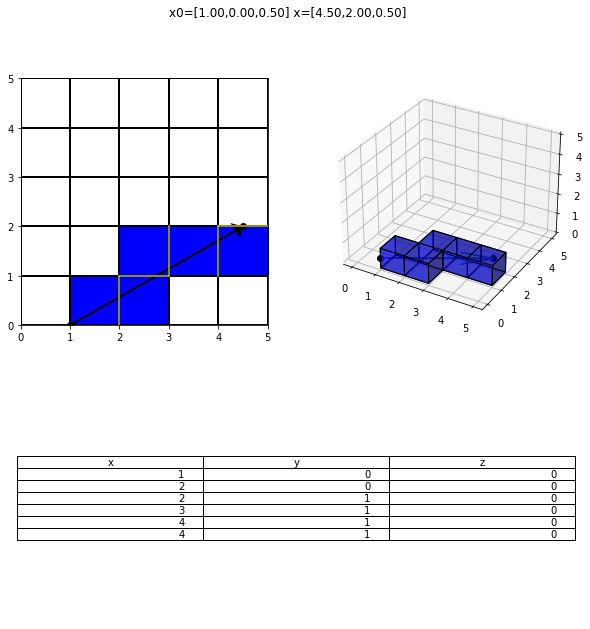

In [5]:
# touch a cell's surface
x0 = np.array([1, 0, 0.5])
x = np.array([4.5, 2.0, 0.5])
print(gen_trj(x0, x))

t_eps =  3.333333333333333e-07
xf= [1.5 1.  0.5]
tMax =  [0.5 1.  inf]
tMax =  [0.83333333 1.                inf]
tMax =  [1.16666667 1.                inf]
Particle touches a cell surface at (1,1,0) -y
[[4, 1, 0, -1, -1], [3, 1, 0, 0, 1], [2, 1, 0, 0, 1], [1, 1, 0, 0, 1], [1, 1, 0, 1, 0]]


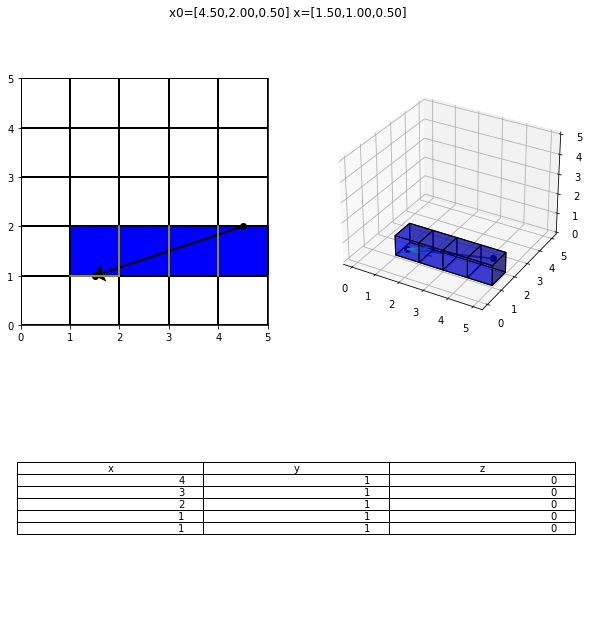

In [6]:
# touch a cell's surface
x = np.array([1.5, 1, 0.5])
x0 = np.array([4.5, 2.0, 0.5])
print(gen_trj(x0, x))

t_eps =  2.857142857142857e-07
xf= [1.  1.  0.5]
tMax =  [0.42857143 1.                inf]
tMax =  [0.71428571 1.                inf]
tMax =  [ 1.  1. inf]
Particle touches an edge
[[4, 1, 0, -1, -1], [3, 1, 0, 0, 1], [2, 1, 0, 0, 1], [1, 1, 0, 0, 1], [1, 1, 0, -1, -1]]


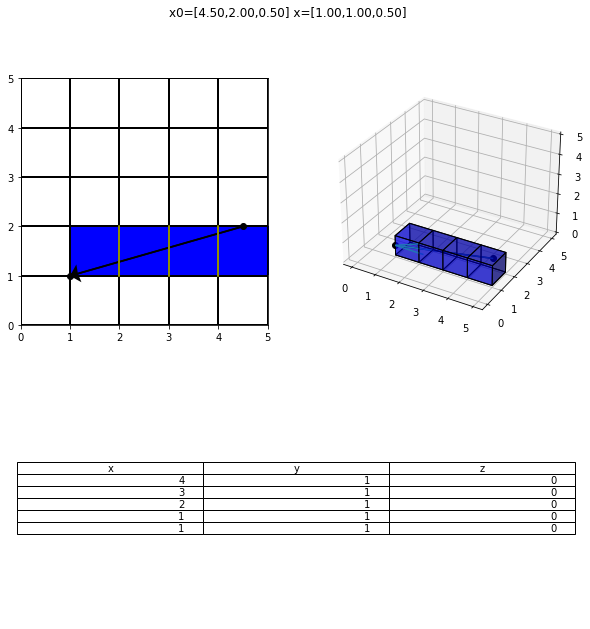

In [7]:
# touch an edge
x = np.array([1, 1, 0.5])
x0 = np.array([4.5, 2.0, 0.5])
print(gen_trj(x0, x))

t_eps =  2.857142857142857e-07
xf= [1 1 1]
tMax =  [0.42857143 1.         0.5       ]
tMax =  [0.71428571 1.         0.5       ]
tMax =  [0.71428571 1.         1.        ]
tMax =  [1. 1. 1.]
Particle touches a vertex
[[4, 1, 2, -1, -1], [3, 1, 2, 0, 1], [2, 1, 2, 0, 1], [2, 1, 1, 2, 1], [1, 1, 1, 0, 1], [1, 1, 1, -1, -1]]


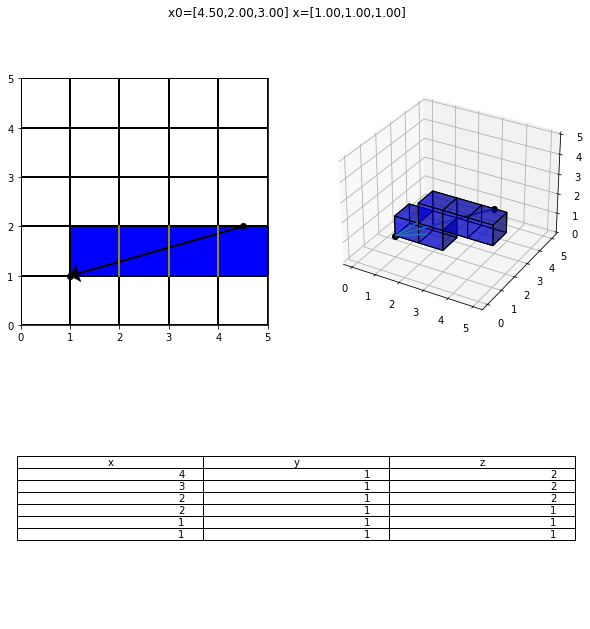

In [8]:
# touches a vertex
x = np.array([1, 1, 1])
x0 = np.array([4.5, 2.0, 3])
print(gen_trj(x0, x))

t_eps =  2.857142857142857e-07
xf= [1.  2.  1.1]
tMax =  [0.14285714        inf 0.55      ]
tMax =  [0.42857143        inf 0.55      ]
tMax =  [0.71428571        inf 0.55      ]
tMax =  [0.71428571        inf 1.05      ]
tMax =  [1.    inf 1.05]
Particle touches a cell surface at (1,2,1) -x
[[4, 2, 3, -1, -1], [4, 2, 2, 2, 1], [3, 2, 2, 0, 1], [2, 2, 2, 0, 1], [2, 2, 1, 2, 1], [1, 2, 1, 0, 1], [1, 2, 1, 0, 0]]


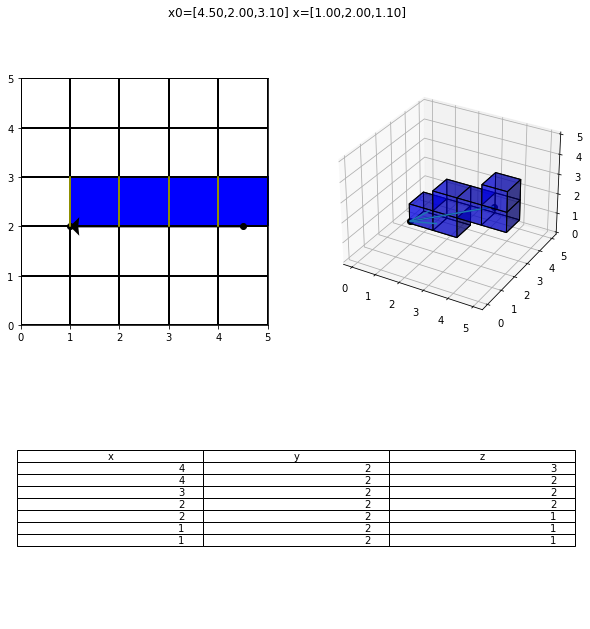

In [9]:
# moves on grid line
x = np.array([1, 2, 1.1])
x0 = np.array([4.5, 2, 3.1])
print(gen_trj(x0, x))